In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from cmath import nan

In [3]:
def fill_flag(sample):
    if not isinstance(sample['Flag'], str):
        col = 'Data' + str(sample['DLC'])
        sample['Flag'], sample[col] = sample[col], sample['Flag']
    return sample

In [4]:
attack = 'RPM'
columns = ['Timestamp', 'ID', 'DLC', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4',
       'Data5', 'Data6', 'Data7', 'Flag']
df = pd.read_csv('../Data/Car-Hacking/{}_dataset.csv'.format(attack), names=columns)
df = df.apply(fill_flag, axis=1)
df = df.fillna(0)
df

,Timestamp,ID,DLC,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Flag
0,1.478191e+09,0316,8,05,22,68,09,22,20,00,75,R
1,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
2,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
3,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
4,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R
...,...,...,...,...,...,...,...,...,...,...,...,...
4621697,1.478201e+09,018f,8,fe,59,00,00,00,41,00,00,R
4621698,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,19,R
4621699,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,00,R
4621700,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,14,R


In [5]:
df['Flag'] = (df['Flag'] == 'T')
transform_cols = ['ID'] + ['Data'+str(x) for x in range(8)]
types = ['int16'] + ['int16' for _ in range(8)]
for c, t in zip(transform_cols, types):
    df['transformed_'+c] = df[c].map(lambda x: int(str(x), 16))
    df['transformed_'+c] = df['transformed_'+c].astype(t)
df

,Timestamp,ID,DLC,Data0,Data1,Data2,Data3,Data4,Data5,Data6,...,Flag,transformed_ID,transformed_Data0,transformed_Data1,transformed_Data2,transformed_Data3,transformed_Data4,transformed_Data5,transformed_Data6,transformed_Data7
0,1.478191e+09,0316,8,05,22,68,09,22,20,00,...,False,790,5,34,104,9,34,32,0,117
1,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,...,False,399,254,59,0,0,0,60,0,0
2,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,...,False,608,25,34,34,48,255,143,110,63
3,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,...,False,672,96,0,131,29,150,2,189,0
4,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,...,False,809,220,184,126,20,17,32,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621697,1.478201e+09,018f,8,fe,59,00,00,00,41,00,...,False,399,254,89,0,0,0,65,0,0
4621698,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,...,False,608,24,33,33,48,8,143,109,25
4621699,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,...,False,672,36,0,154,29,151,2,189,0
4621700,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,...,False,809,220,183,127,20,17,32,0,20


In [6]:
from numpy.lib.stride_tricks import as_strided

def sliding_window(data, win=29, s=1):
    itemsize  = data.itemsize
    N = len(data)
    sliding_data = as_strided(data, shape=((N - win) // s + 1, win), strides=(itemsize*s, itemsize))
    return sliding_data


In [7]:
feats = {}
for c in transform_cols:
    data = df['transformed_'+c].to_numpy()
    sliding_data = sliding_window(data, win=29, s=14)
    feats[c] = pd.Series(sliding_data.tolist())

sliding_label = sliding_window(df['Flag'].to_numpy(), win=29, s=14)
sliding_label = np.any(sliding_label, axis=1).astype('int8')
feats['Label'] = sliding_label

In [8]:
pp_df = pd.DataFrame(feats)
pp_df

,ID,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Label
0,"[790, 399, 608, 672, 809, 1349, 704, 2, 339, 3...","[5, 254, 25, 96, 220, 216, 21, 0, 0, 3, 0, 0, ...","[34, 59, 34, 0, 184, 0, 0, 0, 33, 128, 128, 0,...","[104, 0, 34, 131, 126, 0, 0, 0, 16, 0, 0, 0, 9...","[9, 0, 48, 29, 20, 131, 0, 0, 255, 255, 0, 0, ...","[34, 0, 255, 150, 17, 0, 0, 0, 0, 46, 62, 4, 1...","[32, 60, 143, 2, 32, 0, 0, 7, 255, 128, 127, 0...","[0, 0, 110, 189, 0, 0, 0, 9, 0, 9, 9, 41, 8, 0...","[117, 0, 63, 0, 20, 0, 0, 6, 0, 238, 246, 126,...",0
1,"[1088, 848, 1264, 790, 399, 608, 672, 809, 134...","[255, 5, 0, 5, 254, 25, 0, 220, 216, 21, 0, 0,...","[0, 32, 0, 34, 59, 34, 0, 184, 0, 0, 0, 0, 0, ...","[0, 68, 0, 104, 0, 34, 131, 126, 0, 0, 0, 0, 0...","[0, 104, 128, 9, 0, 48, 29, 20, 131, 0, 0, 0, ...","[255, 114, 0, 34, 0, 255, 150, 17, 0, 0, 0, 0,...","[172, 0, 103, 32, 60, 143, 2, 32, 0, 0, 0, 0, ...","[8, 0, 209, 0, 0, 110, 189, 0, 0, 0, 0, 0, 0, ...","[0, 123, 19, 117, 0, 12, 0, 20, 0, 0, 0, 0, 0,...",0
2,"[2, 304, 305, 320, 880, 1087, 1088, 848, 1680,...","[0, 2, 251, 0, 0, 0, 255, 5, 0, 5, 254, 25, 32...","[0, 128, 127, 0, 32, 64, 0, 32, 0, 34, 59, 34,...","[0, 0, 0, 0, 0, 96, 0, 84, 1, 108, 0, 34, 131,...","[0, 255, 0, 0, 0, 255, 0, 104, 0, 9, 0, 48, 29...","[0, 34, 56, 2, 0, 112, 255, 115, 160, 34, 0, 2...","[8, 128, 127, 18, 0, 170, 170, 0, 2, 32, 60, 1...","[10, 10, 10, 42, 0, 8, 8, 0, 0, 0, 0, 110, 189...","[130, 158, 65, 112, 0, 0, 0, 106, 0, 117, 0, 2...",0
3,"[1349, 1520, 704, 2, 339, 304, 305, 320, 1087,...","[216, 1, 21, 0, 0, 5, 9, 0, 0, 0, 255, 5, 0, 5...","[89, 0, 0, 0, 33, 128, 128, 0, 64, 32, 0, 32, ...","[0, 0, 0, 0, 16, 0, 0, 0, 96, 0, 0, 100, 0, 10...","[132, 0, 0, 0, 255, 255, 0, 0, 255, 0, 0, 104,...","[0, 0, 0, 0, 0, 52, 55, 4, 112, 0, 255, 115, 0...","[0, 0, 0, 8, 255, 128, 127, 15, 168, 0, 168, 0...","[0, 0, 0, 11, 0, 11, 11, 43, 8, 0, 8, 0, 209, ...","[0, 0, 0, 159, 0, 16, 192, 231, 0, 0, 0, 90, 1...",0
4,"[399, 608, 672, 809, 1349, 704, 1072, 1201, 49...","[254, 25, 64, 12, 216, 21, 0, 0, 8, 0, 0, 93, ...","[59, 34, 0, 184, 0, 0, 0, 0, 0, 33, 0, 130, 13...","[0, 34, 131, 126, 0, 0, 0, 0, 0, 16, 0, 108, 0...","[0, 48, 29, 20, 133, 0, 0, 0, 0, 255, 0, 9, 0,...","[0, 255, 150, 17, 0, 0, 0, 0, 0, 0, 0, 0, 36, ...","[60, 143, 2, 32, 0, 0, 0, 0, 0, 255, 8, 31, 0,...","[0, 111, 189, 0, 0, 0, 0, 0, 0, 0, 12, 2, 0, 1...","[0, 45, 0, 20, 0, 0, 0, 0, 0, 0, 204, 0, 0, 10...",0
...,...,...,...,...,...,...,...,...,...,...
330115,"[1349, 704, 880, 1087, 1088, 2, 339, 304, 305,...","[216, 20, 0, 0, 255, 0, 0, 24, 247, 0, 5, 0, 0...","[90, 0, 32, 64, 0, 0, 33, 128, 127, 0, 32, 0, ...","[0, 0, 0, 96, 0, 0, 16, 0, 0, 0, 52, 0, 1, 28,...","[138, 0, 0, 255, 0, 0, 255, 255, 0, 0, 104, 12...","[0, 0, 0, 126, 255, 0, 0, 16, 49, 14, 117, 0, ...","[0, 0, 0, 131, 131, 1, 255, 128, 127, 37, 0, 1...","[0, 0, 0, 9, 9, 5, 0, 5, 5, 37, 0, 209, 0, 0, ...","[0, 0, 0, 0, 0, 47, 0, 223, 194, 249, 12, 19, ...",0
330116,"[399, 608, 672, 809, 1349, 704, 880, 1087, 108...","[254, 25, 36, 134, 216, 20, 0, 0, 255, 0, 41, ...","[89, 34, 0, 183, 0, 0, 32, 64, 0, 0, 39, 0, 33...","[0, 34, 154, 127, 0, 0, 0, 96, 0, 0, 39, 0, 16...","[0, 48, 29, 20, 138, 0, 0, 255, 0, 0, 35, 0, 2...","[0, 8, 151, 17, 0, 0, 0, 126, 255, 0, 0, 0, 0,...","[65, 143, 2, 32, 0, 0, 0, 132, 132, 0, 0, 0, 2...","[0, 112, 189, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 6,...","[0, 20, 0, 20, 0, 0, 0, 0, 0, 0, 154, 0, 0, 8,...",0
330117,"[848, 304, 305, 320, 790, 399, 608, 672, 809, ...","[5, 24, 0, 0, 5, 254, 24, 68, 134, 216, 20, 0,...","[32, 128, 128, 0, 34, 89, 34, 0, 183, 0, 0, 32...","[68, 0, 0, 0, 28, 0, 34, 154, 127, 0, 0, 0, 96...","[104, 255, 0, 0, 10, 0, 48, 29, 20, 137, 0, 0,...","[117, 15, 48, 16, 34, 0, 8, 151, 17, 0, 0, 0, ...","[0, 128, 127, 39, 30, 65, 143, 2, 32, 0, 0, 0,...","[0, 6, 6, 38, 0, 0, 112, 189, 0, 0, 0, 0, 9, 9...","[124, 102, 68, 87, 111, 0, 38, 0, 20, 0, 0, 0,...",0
330118,"[1520, 2, 339, 304, 305, 320, 848, 1264, 790, ...","[1, 0, 0, 24, 0, 0, 5, 0, 5, 254, 24, 100, 134.

In [11]:
pp_df.Label.value_counts()

0    182305
1    147815
Name: Label, dtype: int64

In [10]:
save_dir = '../Data/CHD_w29_s14_ID_Data/'
pp_df.to_csv(save_dir + f'{attack}.csv', header=True, index=False)

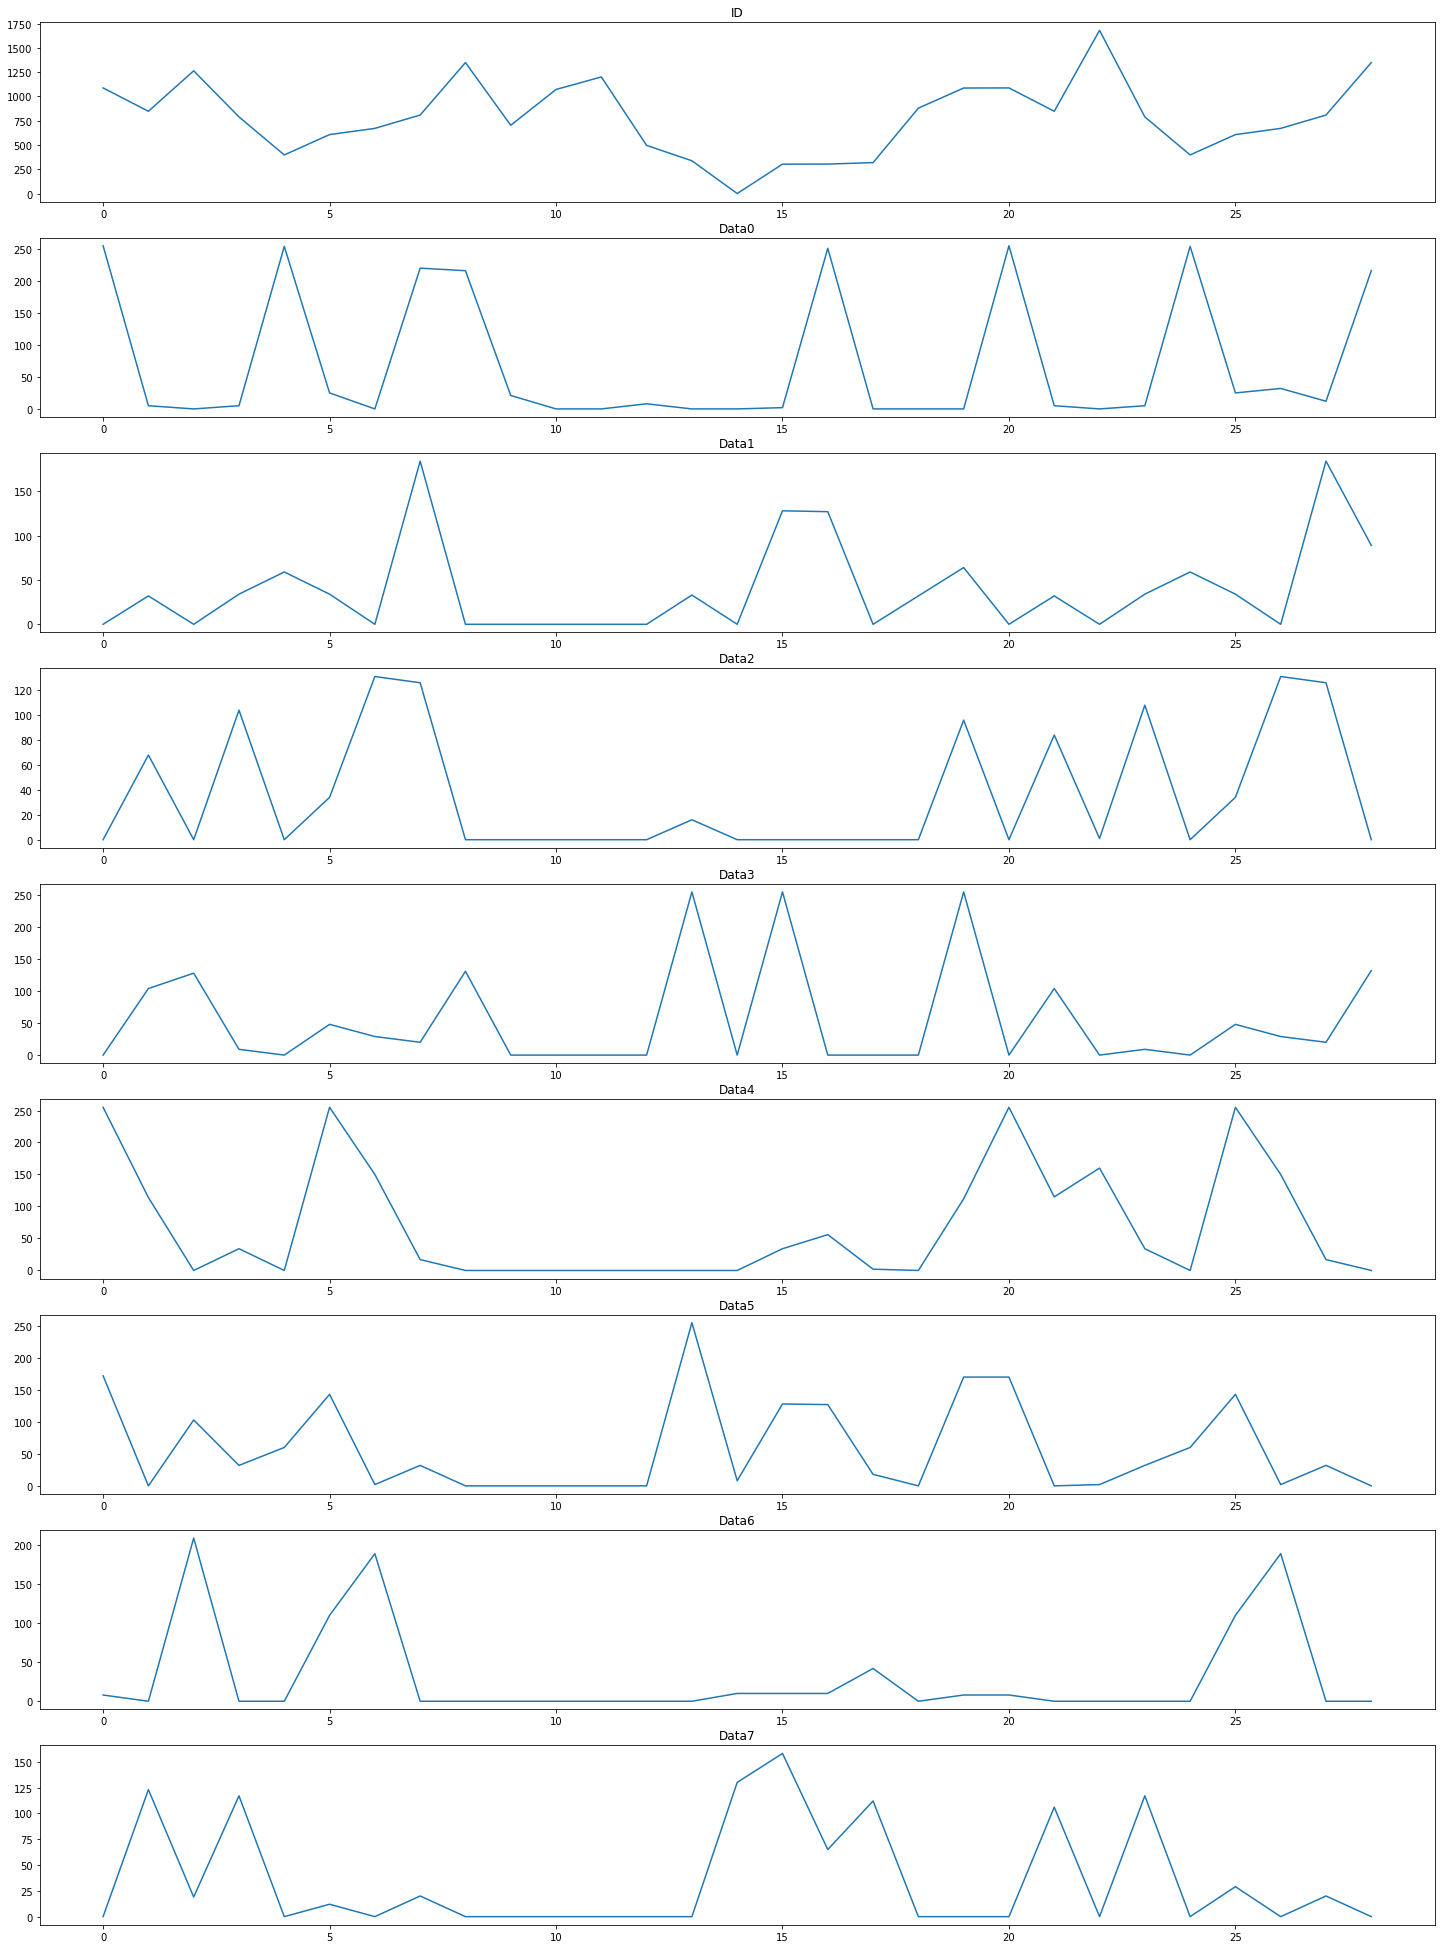

In [13]:
cols = pp_df.columns[:-1]
fig, ax = plt.subplots(nrows=len(cols), ncols=1, figsize=(25, 35))
start = 0
window = 29
for i, name in enumerate(cols):
    data = pp_df[name][1]
    ax[i].plot(data)
    ax[i].set_title(name)

In [14]:
cols

Index(['ID', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6',
       'Data7'],
      dtype='object')

normal


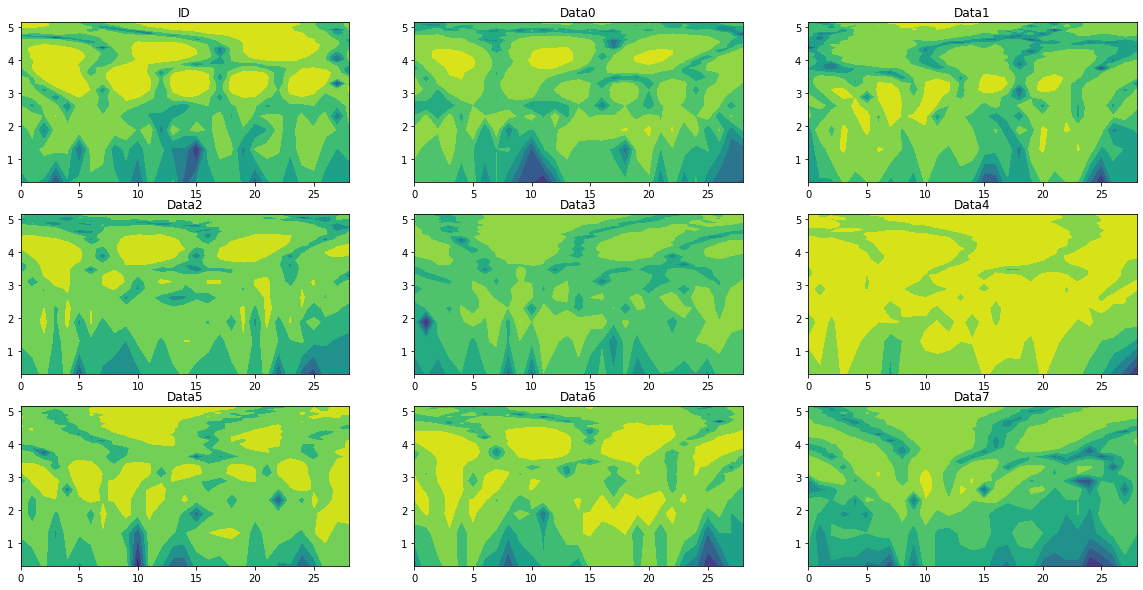

In [21]:
import pywt
sample = pp_df.iloc[0]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
print('Label: ' + ('attack' if sample['Label'] else 'normal'))
for c, ax in zip(cols, axs.flat):
    signal = sample[c] 
    scales = np.arange(1, 30)
    waveletname = 'morl'
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname)
    power = (np.abs(coefficients))**2
    time = np.arange(29)
    periods = 1/frequencies
    im = ax.contourf(time, np.log2(periods), np.log2(power))
    ax.set_title(c)

In [19]:
# time_range in sec
def count_message_within(df, time_range=1):
    bins = np.arange(start=df.Timestamp.min(), stop=df.Timestamp.max(), step=time_range)
    split_time_interval = pd.cut(df['Timestamp'], bins, include_lowest=True)
    cnt = df.groupby(split_time_interval).count()['Timestamp'].tolist()
    return cnt 

In [20]:
cnts = count_message_within(df, time_range=0.01)

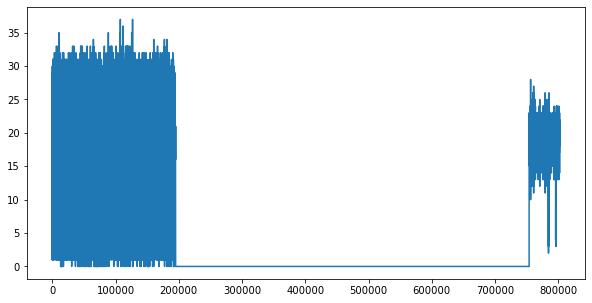

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(cnts)

In [48]:
pd.DataFrame(cnts).describe()

,0
count,801900.000000
mean,5.540746
std,9.062434
min,0.000000
25%,0.000000
50%,0.000000
75%,16.000000
max,37.000000
